In [845]:
import numpy as np
import matplotlib.pyplot as plt

# NN Dev

## Functions

In [846]:
def sigmoid(x_):
    x_ = (x_ > -200) * x_
    return 1 / (1 + np.exp(-x_))

def d_sigmoid(x_):
    return sigmoid(x_)*(1 - sigmoid(x_))

def relu(x_):
    return x_ * (x_ >= 0)

def d_relu(x_):
    return 1. * (x_ >= 0)

def softmax(x_):
    return np.exp(x_) / np.sum(np.exp(x_))

def d_softmax(x_):
    Ds = np.zeros(shape=(len(x_), len(x_)))
    for i in range(len(x_)):
        for j in range(len(x_)):
            if i == j:
                Ds[i][j] = softmax(x_)[i] * (1 - softmax(x_)[j])
            else:
                Ds[i][j] = -softmax(x_)[i] * softmax(x_)[j]
    return Ds

def se(y_hat_, y_):
    return (y_hat_ - y_)**2

def d_se(y_hat_, y_):
    return 2 * (y_hat_ - y_)

def mse(O, Y):
    N = O.shape[0]
    mse_ = np.zeros(shape=(1, O.shape[1]), dtype=np.float64)
    for i in range(N):
        mse_ += (O[i] - Y[i])**2
    mse_ = (1 / N) * mse_
    return mse_

def d_mse(O, Y):
    N = O.shape[0]
    d_mse_ = np.zeros(shape=(1, O.shape[1]), dtype=np.float64)
    for i in range(N):
        d_mse_ += (O[i] - Y[i])
    d_mse_ = (2 / N) * d_mse_
    return d_mse_

## Layer Net

In [1117]:
class NN:
    def __init__(self, layers, init=(-.5,.5), learning_rate=0.02, dtype = np.float64) -> None:
        self.learning_rate = learning_rate
        self.dtype = dtype
        self.layers = layers
        output_size_prev = self.layers[0]["input_size"]
        for l in self.layers:
            input_size, output_size = l["input_size"], l["output_size"] 
            assert(input_size == output_size_prev)
            l["W"] = self.init_weights(init, input_size, output_size)
            output_size_prev = output_size

    def init_weights(self, init, input_size, output_size):
        return np.random.uniform(low=init[0], high=init[1], size=(output_size, input_size)).astype(self.dtype)
    
    def forward(self, x_):
        A_prev = x_
        for l in self.layers:
            Z_curr = l["W"] @ A_prev
            A_curr = l["activation"](Z_curr)
            l["memory"] = (Z_curr.copy(), A_prev.copy())
            A_prev = A_curr
        return A_curr
    
    def backward(self, y_hat_, y_):
        i = -1
        z_, a_prev_ = self.layers[i]["memory"]
        d_f = self.layers[i]['d_activation'](z_)
        mem = d_f @ d_se(y_hat_, y_)
        self.layers[i]['dW'] = mem @ a_prev_.T 
        for i in list(range(len(self.layers)-2,-1,-1)):
            z_, a_prev_ = self.layers[i]["memory"]
            d_f = self.layers[i]['d_activation'](z_)
            mem = self.layers[i + 1]['W'].T @ mem * d_f
            self.layers[i]['dW'] = mem @ a_prev_.T


    def train(self, X, Y, epochs=1):
        for e in range(epochs):
            self.outputs = []
            self.losses = []
            for i in range(X.shape[0]):
                y_hat_ = self.forward(X[i])
                if len(self.outputs) == 0:
                    self.outputs = y_hat_
                else:
                    np.append(self.outputs, y_hat_, axis=0)
                y_ = Y[i]
                self.losses.append(se(y_hat_, y_))
                self.backward(y_hat_, y_)
                for l in self.layers:
                    l['W'] = l['W'] - self.learning_rate * l['dW']
        return self.losses

## Layer Net Testing

### Init test

In [848]:
layers = [{"input_size": 4, "output_size": 5, "activation": sigmoid, "d_activation": d_sigmoid},
          {"input_size": 5, "output_size": 5, "activation": sigmoid, "d_activation": d_sigmoid},
          {"input_size": 5, "output_size": 4, "activation": sigmoid, "d_activation": d_sigmoid},
          {"input_size": 4, "output_size": 3, "activation": softmax, "d_activation": d_softmax}]
nn = NN(layers)
nn.layers

[{'input_size': 4,
  'output_size': 5,
  'activation': <function __main__.sigmoid(x_)>,
  'd_activation': <function __main__.d_sigmoid(x_)>,
  'W': array([[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]])},
 {'input_size': 5,
  'output_size': 5,
  'activation': <function __main__.sigmoid(x_)>,
  'd_activation': <function __main__.d_sigmoid(x_)>,
  'W': array([[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]])},
 {'input_size': 5,
  'output_size': 4,
  'activation': <function __main__.sigmoid(x_)>,
  'd_activation': <function __main__.d_sigmoid(x_)>,
  'W': array([[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]])},
 {'input_size': 4,
  'output_size': 3,
  'activation': <function __main__.softmax(x_)>,
  'd_activation': <function __main__.d_softmax(x_)>

### Backprop

In [849]:
X = np.array([[0, 0, 0, 1], [0, 0, 0, 1]])
X = X.reshape(X.shape[0],X.shape[1],1)
Y= np.array([[0, 1, 0], [0, 1, 0]])
Y = Y.reshape(Y.shape[0],Y.shape[1],1)

y_hat_ = nn.forward(X[0])
y_ = Y[0]

d_Cf = d_se(y_hat_, y_)
mem = d_Cf
for idx, layer in reversed(list(enumerate(nn.layers))):
    print(idx)
    z_, a_prev_ = layer["memory"]
    d_f = layer['d_activation'](z_)
    if layer['d_activation'] == d_softmax:
        mem = d_f @ mem
    else:
        mem = nn.layers[idx + 1]['W'].T @ mem * d_f
    layer['dW'] = mem @ a_prev_.T
    print(layer["dW"].shape)
    print(layer["W"].shape)


3
(3, 4)
(3, 4)
2
(4, 5)
(4, 5)
1
(5, 5)
(5, 5)
0
(5, 4)
(5, 4)


In [850]:
# (n?,k),(k,m?)->(n?,m?)

In [851]:
nn.layers[-1]["d_activation"] == d_softmax

True

In [852]:
nn.layers[-1]["W"].shape[0]

3

In [853]:
nn.layers[-1]

{'input_size': 4,
 'output_size': 3,
 'activation': <function __main__.softmax(x_)>,
 'd_activation': <function __main__.d_softmax(x_)>,
 'W': array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]),
 'memory': (array([[3.96966059],
         [3.96966059],
         [3.96966059]]),
  array([[0.99241515],
         [0.99241515],
         [0.99241515],
         [0.99241515]])),
 'dW': array([[ 0.2205367,  0.2205367,  0.2205367,  0.2205367],
        [-0.4410734, -0.4410734, -0.4410734, -0.4410734],
        [ 0.2205367,  0.2205367,  0.2205367,  0.2205367]])}

In [854]:
M = np.array([[1, 2, 3], [1, 2, 3] ,[2, 2, 2]]).reshape(3, 3)
print(M)
a = np.array([1, 2, 3]).reshape(3, 1)
print(a)

[[1 2 3]
 [1 2 3]
 [2 2 2]]
[[1]
 [2]
 [3]]


In [855]:
np.sum(M, axis=0)

array([4, 6, 8])

In [856]:
M @ a

array([[14],
       [14],
       [12]])

In [857]:
a.T @ M

array([[ 9, 12, 15]])

In [858]:
np.sum(a.T * M, axis=1)

array([14, 14, 12])

In [859]:
np.sum(M * a, axis=0)

array([ 9, 12, 15])

In [860]:
M * a

array([[1, 2, 3],
       [2, 4, 6],
       [6, 6, 6]])

In [861]:
a.T * M

array([[1, 4, 9],
       [1, 4, 9],
       [2, 4, 6]])

In [862]:
M * a.T

array([[1, 4, 9],
       [1, 4, 9],
       [2, 4, 6]])

In [863]:
np.dot(M, a)

array([[14],
       [14],
       [12]])

### Training

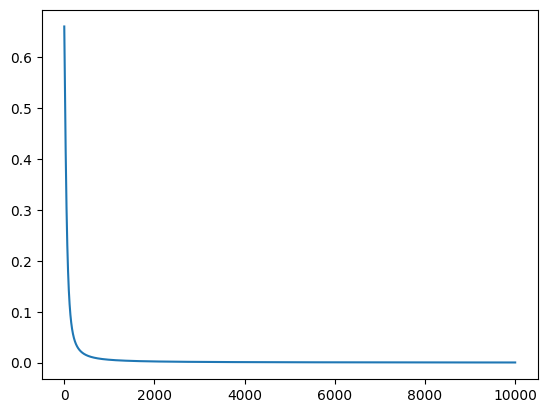

CPU times: total: 2.72 s
Wall time: 2.71 s


In [1100]:
%%time
X = np.array([[0, 0, 0, 1] for _ in range(1000)])
X = X.reshape(X.shape[0],X.shape[1],1)
Y= np.array([[0, 1, 0] for _ in range(1000)])
Y = Y.reshape(Y.shape[0],Y.shape[1],1)
ls = [{"input_size": 4, "output_size": 5, "activation": sigmoid, "d_activation": d_sigmoid},
        {"input_size": 5, "output_size": 5, "activation": sigmoid, "d_activation": d_sigmoid},
          {"input_size": 5, "output_size": 3, "activation": softmax, "d_activation": d_softmax}]
nn2 = NN(ls)

losses = nn2.train(X, Y)
plt.plot([i for i in range(1000)], [np.sum(l) for l in losses])
plt.show()

## First Net

In [1081]:
class NeuralNetwork:
    def __init__(self, input_size, l1_size, l2_size, output_size, init=(-.5,.5), learning_rate= 0.02, dtype = np.float64):
        self.input_size = input_size
        self.l1_size = l1_size
        self.l2_size = l2_size
        self.output_size = output_size
        
        self.W1 = np.random.uniform(low=init[0], high=init[1], size=(self.input_size, self.l1_size)).astype(dtype)
        # self.W1 = np.ones(shape=(self.input_size, self.l1_size), dtype=dtype)
        self.W2 = np.random.uniform(low=init[0], high=init[1], size=(self.l1_size, self.l2_size)).astype(dtype)
        # self.W2 = np.ones(shape=(self.l1_size, self.l2_size), dtype=dtype) 
        self.W3 = np.random.uniform(low=init[0], high=init[1], size=(self.l2_size, self.output_size)).astype(dtype) 
        # self.W3 np.ones(shape=(self.l2_size, self.output_size), dtype=dtype)

        self.alpha = learning_rate
        
    
    def forward(self, x_):
        # Layer 1
        self.x_ = x_
        self.l1_ = self.x_ @ self.W1
        self.a1_ = sigmoid(self.l1_)
        #self.g1 = d_sigmoid(self.l1_)
        # Layer 2
        self.l2_ = self.a1_ @ self.W2
        self.a2_ = sigmoid(self.l2_)
        #self.g2 = d_sigmoid(self.l2_)
        # Layer 3
        self.o_ = self.a2_ @ self.W3
        self.s_ = softmax(self.o_)
        #self.g3 = d_softmax(self.o_)

        return self.s_
    
    def backward(self, y_, output_):
        tmp = d_se(output_, y_) @ d_softmax(self.o_)
        self.dW3 = self.a2_.reshape(self.l2_size, 1) @ tmp
        tmp2 = d_sigmoid(self.l2_).reshape(self.l2_size, 1) @ (tmp @ self.W3.T)
        self.dW2 = tmp2 * self.a1_.reshape(self.l1_size, 1)
        self.dW1 = (self.x_.reshape(self.input_size, 1) @ d_sigmoid(self.l1_).reshape(self.l1_size, 1).transpose()) @ (tmp2 @ self.W2.T)

        self.W3 = self.W3 - self.alpha * self.dW3
        self.W2 = self.W2 - self.alpha * self.dW2 
        self.W1 = self.W1 - self.alpha * self.dW1
    
    def train(self, X, Y):
        self.outputs = []
        self.losses = []
        for i in range(X.shape[0]):
            output = self.forward(X[i]).reshape((1, self.output_size))
            if len(self.outputs) == 0:
                self.outputs = output
            else:
                np.append(self.outputs, output, axis=0)
            actual = Y[i].reshape((1, self.output_size))
            self.losses.append(se(output, actual))
            self.backward(actual, output)
        return self.losses


## First Net Testing

### NN init test

In [866]:
nn = NeuralNetwork(3, 4, 4, 2, (0, 1))
print(nn.W1.shape)
print(nn.W2.shape)
print(nn.W3.shape)

(3, 4)
(4, 4)
(4, 2)


In [867]:
x_ = np.array([1, 2, 3])
nn.forward(x_)

array([0.59191004, 0.40808996])

### Sigmoid overflow & derivative

In [868]:
sig_test = np.array([0, 1, -1, 1000, -1000])
sigmoid(sig_test)

array([0.5       , 0.73105858, 0.26894142, 1.        , 0.5       ])

In [869]:
d_sigmoid(sig_test)

array([0.25      , 0.19661193, 0.19661193, 0.        , 0.25      ])

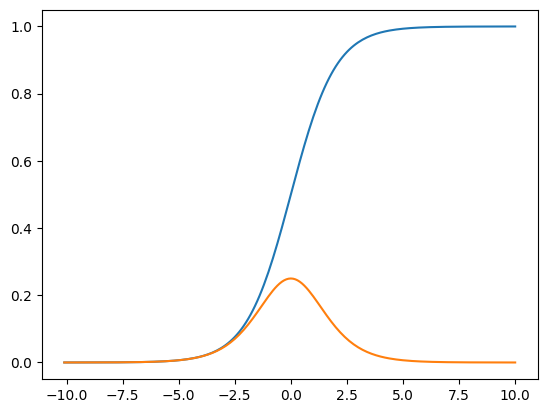

In [870]:
plt.plot([i for i in np.arange(-10.1,10.1,0.1)], [sigmoid(i) for i in np.arange(-10.1,10.1,0.1)])
plt.plot([i for i in np.arange(-10.1,10.1,0.1)], [d_sigmoid(i) for i in np.arange(-10.1,10.1,0.1)])
plt.show()

In [871]:
# check if overflow happens
print(sigmoid(-200.0))
print(sigmoid(-199.0))

0.5
3.761820781096061e-87


### Relu and derivative

In [872]:
rel_test = np.array([0, 1, -1, 1000, -1000, 5])
relu(rel_test)

array([   0,    1,    0, 1000,    0,    5])

In [873]:
d_relu(rel_test)

array([1., 1., 0., 1., 0., 1.])

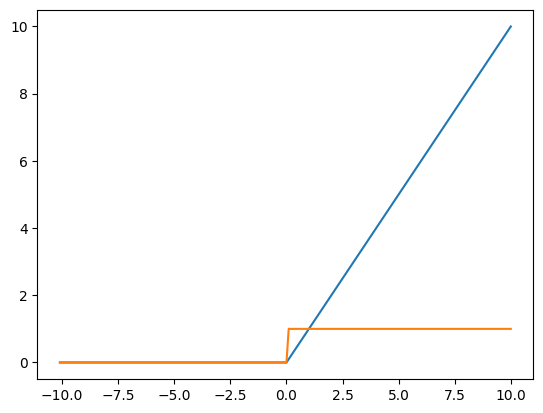

In [874]:
plt.plot([i for i in np.arange(-10.1,10.1,0.1)], [relu(i) for i in np.arange(-10.1,10.1,0.1)])
plt.plot([i for i in np.arange(-10.1,10.1,0.1)], [d_relu(i) for i in np.arange(-10.1,10.1,0.1)])
plt.show()

### Forward pass

In [875]:
a = np.array([1, 2, 3]).reshape(1, 3)
print(a.shape)
print(a)
nn.forward(a[0])

(1, 3)
[[1 2 3]]


array([0.59191004, 0.40808996])

In [876]:
M = 3
K = 5

xv_ = np.arange(0, M).reshape((M,1))
print(xv_.shape)
print(xv_)

W = np.random.uniform(low=0, high=3, size=(K, M)).astype(np.int16)
print(W)

(3, 1)
[[0]
 [1]
 [2]]
[[0 1 0]
 [1 1 2]
 [2 0 1]
 [0 1 1]
 [1 1 1]]


In [877]:
res = W @ xv_
print(res.shape)
res

(5, 1)


array([[1],
       [5],
       [2],
       [3],
       [3]])

In [878]:
res = xv_.transpose() @ W.transpose()
print(res.shape)
res

(1, 5)


array([[1, 5, 2, 3, 3]])

### Softmax derivative

In [879]:
t = np.array([1, 2, 3])
print(t)
print(softmax(t))
print(d_softmax(t))

[1 2 3]
[0.09003057 0.24472847 0.66524096]
[[ 0.08192507 -0.02203304 -0.05989202]
 [-0.02203304  0.18483645 -0.1628034 ]
 [-0.05989202 -0.1628034   0.22269543]]


### MSE derivative

In [880]:
T = np.array([[0, 1, 0], [0, 0, 1]])
print(T)
print(T.shape)
A = np.array([softmax([0, 1, 2]), softmax([1, 2, 0])])
print(A)
print(A.shape)
print(mse(T, A))
print(d_mse(T, A))

[[0 1 0]
 [0 0 1]]
(2, 3)
[[0.09003057 0.24472847 0.66524096]
 [0.24472847 0.66524096 0.09003057]]
(2, 3)
[[0.03399876 0.50649031 0.63529494]]
[[-0.33475904  0.09003057  0.24472847]]


### Backward pass, loss, weight update

In [881]:
hidden_dim = 5
X = np.array([[0, 0, 0, 1]])
Y= np.array([[0, 1, 0]])
nn = NeuralNetwork(X.shape[1], hidden_dim, hidden_dim, Y.shape[1], (-0.3,0.3), 0.02, np.float64)

output_ = nn.forward(X[0]).reshape((1, nn.output_size))
y_ = Y[0].reshape((1, nn.output_size))
print(f"Output :{output_.shape}")
print(f"d MSE :{d_mse(output_, y_).shape}")
print(f"d Softmax :{d_softmax(nn.o_).shape}")
print(f"Activation2 :{nn.a2_.reshape(nn.l2_size, 1).shape}")
print(f"W3 :{nn.W3.shape}")
tmp = d_mse(output_, y_) @ d_softmax(nn.o_)
nn.dW3 = nn.a2_.reshape(nn.l2_size, 1) @ tmp
print(f"W3 update :{nn.dW3.shape}")
print("--------------------------------------------------------------------------------------------------")
print(f"d Sigmoid2 :{d_sigmoid(nn.l2_).reshape(nn.l1_size, 1).shape}")
print(f"Activation1 :{nn.a1_.reshape(nn.l1_size, 1).shape}")
print(f"W2 :{nn.W2.shape}")
# TODO fix this update
tmp2 = d_sigmoid(nn.l2_).reshape(nn.l2_size, 1) @ (tmp @ nn.W3.transpose())
nn.dW2 = tmp2 * nn.a1_.reshape(nn.l2_size, 1)
print(f"W2 update:{nn.dW2.shape}")
print("--------------------------------------------------------------------------------------------------")
print(f"d Sigmoid1 :{d_sigmoid(nn.l1_).reshape(nn.l1_size, 1).shape}")
print(f"X :{X[0].reshape(nn.input_size, 1).shape}")
print(f"W1 :{nn.W1.shape}")
# TODO fix this update
nn.dW1 = (nn.x_.reshape(nn.input_size, 1) @ d_sigmoid(nn.l1_).reshape(nn.l1_size, 1).transpose()) @ (tmp2 @ nn.W2.transpose())
print(f"W1 update:{nn.dW1.shape}")

Output :(1, 3)
d MSE :(1, 3)
d Softmax :(3, 3)
Activation2 :(5, 1)
W3 :(5, 3)
W3 update :(5, 3)
--------------------------------------------------------------------------------------------------
d Sigmoid2 :(5, 1)
Activation1 :(5, 1)
W2 :(5, 5)
W2 update:(5, 5)
--------------------------------------------------------------------------------------------------
d Sigmoid1 :(5, 1)
X :(4, 1)
W1 :(4, 5)
W1 update:(4, 5)


In [882]:
hidden_dim = 5
X = np.array([[0, 0, 0, 1]])
Y= np.array([[0, 1, 0]])
nn = NeuralNetwork(X.shape[1], hidden_dim, hidden_dim, Y.shape[1], (-0.3,0.3), 0.02, np.float64)

from IPython.display import clear_output

def do_iteration(i):
    clear_output()
    print(f"Iteration: {i}")
    out = nn.forward(X[0]).reshape((1, nn.output_size))
    print("Prediction")
    print(f"Net output: {out}  --> {np.argmax(out)}")
    act =  Y[0].reshape(1,3)
    print("Expected value")
    print(f"One Hot: {act}  --> {np.argmax(act)}")
    loss = np.sum(mse(out,act))
    print(f"Loss: {loss}")
    nn.backward(act, out)
    return loss

#### Manually Click an watch loss go down

In [883]:
i = 0
do_iteration(i)
i += 1

Iteration: 0
Prediction
Net output: [[0.33069779 0.28622124 0.38308096]]  --> 2
Expected value
One Hot: [[0 1 0]]  --> 1
Loss: 0.7655921658610986


#### Plot loss over many iterations

Iteration: 999
Prediction
Net output: [[0.03170687 0.93577784 0.03251529]]  --> 1
Expected value
One Hot: [[0 1 0]]  --> 1
Loss: 0.006187055522402923


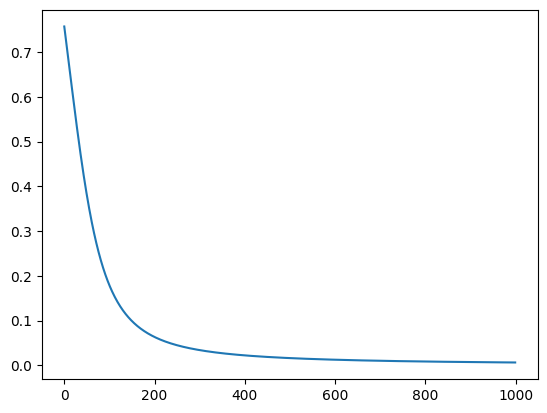

In [884]:
iterations = []
losses = []
for i in range(1000):
    iterations.append(i)
    losses.append(do_iteration(i))

plt.plot(iterations, losses)
plt.show()

### Training

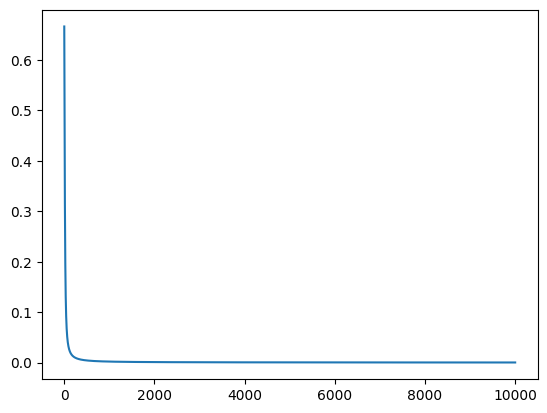

CPU times: total: 2.64 s
Wall time: 2.64 s


In [1099]:
%%time
hidden_dim = 5
X = np.array([[0, 0, 0, 1] for _ in range(1000)])
Y= np.array([[0, 1, 0] for _ in range(1000)])
nn1 = NeuralNetwork(X.shape[1], hidden_dim, hidden_dim, Y.shape[1], (2.,2.))
losses = nn1.train(X, Y)
plt.plot([i for i in range(1000)], [np.sum(l) for l in losses])
plt.show()

# MNIST

## Data Prep

In [1101]:
def plot_image(image):
    c = 0
    for pixel in image:
        if pixel > 0:
            print("@", end="")
        else:
            print(".", end="")
        print("   ", end="")
        c += 1
        if c == 28:
            print("\n")
            c = 0

def one_hot(value, N=10):
    vec = np.zeros(N)
    vec[value] = 1
    return vec

with open("./data/train.csv") as f:
    data = f.readlines()
data = data[1:]
data = np.array([[int(x) for x in line.split(",")] for line in data])
data.shape

(42000, 785)

In [1102]:
Y = data[:, [0]]
print(Y.shape)
print(Y[0])
Y = np.array([one_hot(c) for c in Y])
print(Y.shape)

X = data[:, 1:]
print(X.shape)
plot_image(X[0])

(42000, 1)
[1]
(42000, 10)
(42000, 784)
.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   @   @   @   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   @   @   @   @   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   @   @   @   @   @   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   @   @   @   @   @   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   

## Helpers

In [899]:
def rolling_mean(series, window):
    rolled = []
    c = 0
    mean = 0
    for i in series:
        if c < window:
            mean += i / window
            c += 1
        else:
            c = 0
            rolled.append(mean)
            mean = 0
    return rolled

In [900]:
params = {"init": (-.5, .5), "learning_rate": 0.02}

## Old NN

In [1111]:
hidden_dim = 256
mnist_nn1 = NeuralNetwork(X.shape[1], hidden_dim, hidden_dim, Y.shape[1], **params)

In [1112]:
losses = mnist_nn1.train(X, Y)

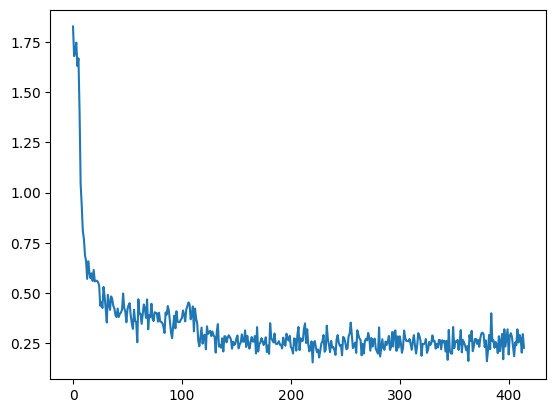

In [1113]:
rolled = rolling_mean([np.sum(l) for l in losses], 100)
plt.plot([i for i in range(len(rolled))], rolled)
plt.show()

In [1114]:
accuracy = 0
for i in range(len(X)):
    prediction = np.argmax(mnist_nn1.forward(X[i]))
    actual = np.where(Y[i] == 1)[0][0]
    accuracy += int(actual == prediction)
accuracy / len(X)

0.8481190476190477

## New NN

In [1118]:
layers = [{"input_size": X.shape[1], "output_size": 256, "activation": sigmoid, "d_activation": d_sigmoid},
          {"input_size": 256, "output_size": 256, "activation": sigmoid, "d_activation": d_sigmoid},
          {"input_size": 256, "output_size": Y.shape[1], "activation": softmax, "d_activation": d_softmax}]
mnist_nn2 = NN(layers, **params)

In [1119]:
new_losses = mnist_nn2.train(X.reshape(X.shape[0],X.shape[1],1), Y.reshape(Y.shape[0],Y.shape[1],1), epochs=2)

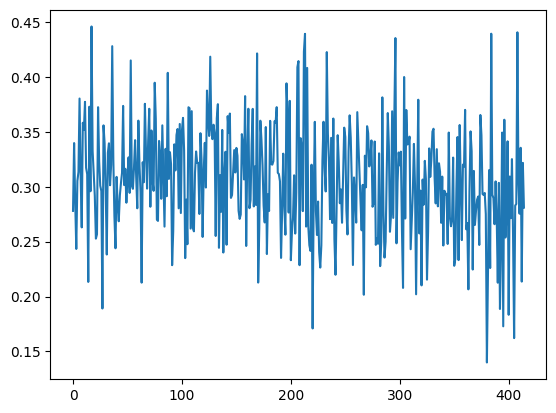

In [1120]:
rolled = rolling_mean([np.sum(l) for l in new_losses], 100)
plt.plot([i for i in range(len(rolled))], rolled)
plt.show()

In [1121]:
accuracy = 0
for i in range(len(X)):
    prediction = np.argmax(mnist_nn2.forward(X[i]))
    actual = np.where(Y[i] == 1)[0][0]
    accuracy += int(actual == prediction)
accuracy / len(X)

0.804404761904762